In [1]:
!pip install efficientnet #needed for train_effnet.py

In [0]:
#!python train_resnet.py --help
#!python train_effnet.py --help

#!python train_effnet.py --test_size 256 --batch_size 1024 --loop 10 --max_patience 1
#!python train_resnet.py --test_size 256 --batch_size 1024 --loop 10 --max_patience 1

In [2]:
!mkdir images_aligned

In [3]:
!python align_images.py images_raw/ images_aligned/  #Cut all images in folder

Using TensorFlow backend.
Aligning 000003.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000003_01.png
Aligning 000005.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000005_01.png
Aligning 000002.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000002_01.png
Aligning 000007.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000007_01.png
Aligning .DS_Store ...
Getting landmarks...
Exception in landmark detection!
Aligning 000009.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000009_01.png
Aligning 000008.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000008_01.png
Aligning 000006.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned/000006_01.png
Aligning 000004.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result images_aligned

In [4]:
!python encode_images.py --batch_size=1 --output_video=True --load_effnet=data/finetuned_effnet images_aligned/ images_generate/ images_latent/


W1003 06:25:17.752247 140386726864640 deprecation_wrapper.py:119] From /home/ubuntu/Insight_Project/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W1003 06:25:17.752921 140386726864640 deprecation_wrapper.py:119] From /home/ubuntu/Insight_Project/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1003 06:25:17.753056 140386726864640 deprecation_wrapper.py:119] From /home/ubuntu/Insight_Project/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

Using TensorFlow backend.
W1003 06:25:18.243688 140386726864640 deprecation_wrapper.py:119] From /home/ubuntu/Insight_Project/dnnlib/tflib/tfutil.py:97: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1003 06:25:18.245017 140386726864640 deprecation_wrapper.py:119] From /home/ubuntu/Insight_Project/dnnlib/tflib/tf

In [1]:
!python latent_feature_dataset.py

In [2]:
!python feature_axes.py

Using TensorFlow backend.
W1009 00:37:22.605252 139928106559232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 00:37:22.632042 139928106559232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1009 00:37:22.650159 139928106559232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 00:37:22.652259 139928106559232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_

Original photo...


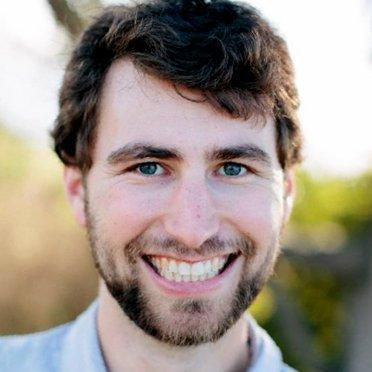



Aligned photo...


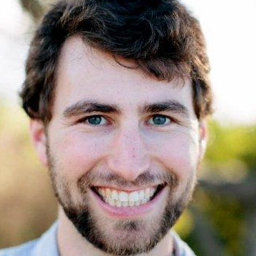



Reconstructed photo...


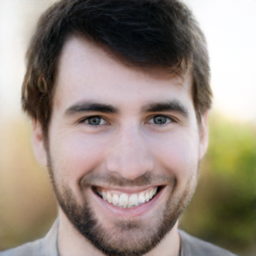

In [4]:
from PIL import Image
import numpy as np
from manipulate_latent import latent_to_image


print('Original photo...')
display(Image.open('./images_raw/000001.jpg'))
print('\n')


print('Aligned photo...')
display(Image.open('./images_aligned/000001_01.png').resize((256,256)))
print('\n')


#from manipulate_latent import latent_to_imageRGB
#image_array = latent_to_imageRGB(image_latent)
#Image.fromarray(image_array, 'RGB').resize((256,256), PIL.Image.LANCZOS)

print('Reconstructed photo...')
image_latent = np.load('./images_latent/000001_01.npy')
latent_to_image(image_latent)


Feature-tuned photo...


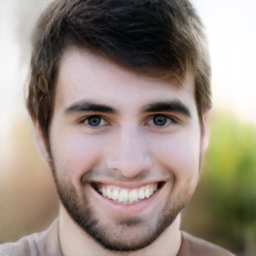

In [5]:
from manipulate_latent import tune_latent

feature_axis = np.load('./data/feature_axis.npy')
i = 1
direction = feature_axis[:,i].reshape((18, 512))
coeff = -15


print('Feature-tuned photo...')
image_latent_tuned = tune_latent(image_latent, direction, coeff, list(range(8)))
latent_to_image(image_latent_tuned)


In [12]:
#Build a GUI interface
import os
import glob
import sys
import numpy as np
import pickle
import tensorflow as tf
import PIL
import ipywidgets
import io
import numpy as np
from manipulate_latent import latent_to_image
from manipulate_latent import latent_to_imageRGB


feature_axis = np.load('./data/feature_axis.npy')
num_feature = feature_axis.shape[1]

feature_ID = ['Gender', 'Age', 'Smile', 'Eye Makeup', 'Lip Makeup', 'Anger', 
              'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 
              'Surprise', 'Beard', 'Moustache', 'Sideburns', 'Bald', 'Blond Hair', 
              'Brown Hair', 'Black Hair', 'Red Hair', 'Gray Hair', 'Other Hair', 'Glasses']


def img_to_bytes(image_RGB):
    imgObj = PIL.Image.fromarray(image_RGB)
    imgByteArr = io.BytesIO()
    imgObj.save(imgByteArr, format='PNG')
    imgBytes = imgByteArr.getvalue()
    return imgBytes


image_latent = np.load('./images_latent/000005_01.npy')
image_RGB = latent_to_imageRGB(image_latent)
w_img = ipywidgets.widgets.Image(value=img_to_bytes(image_RGB), fromat='png', width=512, height=512)


class GuiCallback(object):
    counter = 0
    #dlatent = z_sample
    def __init__(self):
        self.dlatent_original = image_latent.copy()
        self.dlatent = image_latent.copy()
        self.feature_axis = feature_axis
    
    def image_generate(self):        
        image_RGB = latent_to_imageRGB(self.dlatent)
        x_byte = img_to_bytes(image_RGB)
        w_img.value = x_byte
        
    def feature_tune(self, event, idx_feature, step_size=0.1):
        tempt = np.reshape(self.feature_axis[:, idx_feature], (18,512))
        self.dlatent += tempt * step_size
        self.image_generate()
    
    def image_reset(self, event):
        self.dlatent = self.dlatent_original.copy()
        self.image_generate()

guicallback = GuiCallback()


step_size = 0.5
def create_button(idx_feature, width=112, height=64):
    """ function to built button groups for one feature """
    w_feature = ipywidgets.widgets.ToggleButton(value=False, description=feature_ID[idx_feature], 
                                          tooltip='{}, Click to record this feature has be tuned'.format(feature_ID[idx_feature]), 
                                          layout=ipywidgets.Layout(height='{:.0f}px'.format((height-6*3)/2), 
                                                                   width='{:.0f}px'.format(width-6*2), 
                                                                   margin='6px 6px 3px 6px', align_items='stretch'))
    w_neg = ipywidgets.widgets.Button(description='-', 
                                      layout=ipywidgets.Layout(height='{:.0f}px'.format((height-6*3)/2), 
                                                               width='{:.0f}px'.format((width-6*3)/2), 
                                                               margin='3px 3px 6px 6px', align_items='stretch')) 
    w_pos = ipywidgets.widgets.Button(description='+', 
                                      layout=ipywidgets.Layout(height='{:.0f}px'.format((height-6*3)/2), 
                                                               width='{:.0f}px'.format((width-6*3)/2), 
                                                               margin='3px 6px 6px 3px', align_items='stretch'))
    
    #w_feature.on_click(lambda event: guicallback.feature_reset(event, idx_feature))
    w_neg.on_click(lambda event: guicallback.feature_tune(event, idx_feature, step_size =- step_size))
    w_pos.on_click(lambda event: guicallback.feature_tune(event, idx_feature, step_size =+ step_size))
    
    button_group = ipywidgets.VBox([w_feature, ipywidgets.HBox([w_neg, w_pos])],
                                  layout=ipywidgets.Layout(border='1px solid gray', margin = '1px'))
    
    return button_group

In [13]:
list_buttons = []
for idx_feature in range(num_feature):
    list_buttons.append(create_button(idx_feature))

    
def arrange_buttons(list_buttons, ncol=4):
    num = len(list_buttons)
    layout_all_buttons = ipywidgets.VBox([ipywidgets.HBox(list_buttons[i*ncol:(i+1)*ncol]) for i in range(num//ncol+int(num%ncol>0))])
    return layout_all_buttons
    

w_button_reset = ipywidgets.widgets.Button(tooltip='Reset to untuned photo',  
                                           description='Image Reset', button_style='success',
                                           layout=ipywidgets.Layout(height='52px', 
                                                                    width='250px', 
                                                                    margin='6px 6px 6px 6px', 
                                                                    align_items='stretch'))
w_button_reset.on_click(guicallback.image_reset)

w_box = ipywidgets.HBox([w_img, ipywidgets.VBox([w_button_reset, arrange_buttons(list_buttons)])], 
                        layout=ipywidgets.Layout(height='1048}px', width='1096px'))


In [14]:
print('Click +/- to tune feature')
display(w_box)

Click +/- to tune feature
